In [2]:
import os
import dill
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import gudhi 
import tensorflow as tf


from sklearn import preprocessing
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Input, concatenate,Permute, Reshape, GRU,Add
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D ,LeakyReLU ,BatchNormalization ,MaxPooling2D , Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from keras.utils import plot_model

from PIL import Image
from matplotlib import image
from matplotlib import pyplot


Using TensorFlow backend.


# Presetting

In [0]:
artist_folder='artists' 
save_folder='Total_data'
barcode_folder='barcode'
song_folder='song_data'
diagram_folder = 'diagram'
savemodel_folder = 'modelsave'

sr = 16000
# n_mels =128
# n_mels =256

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
seconds = 20
# seconds = 30

epochs = 1
learning_rate = 1e-3

# Function

In [0]:
def generate_barcode_dataset(artist_folder='artists',barcode_folder='barcode',save_folder='Total_data',sr = 16000, n_mels = 256):
    '''
    D.Ellis(2007) Classitying Music Audio with Timbral and Chroma Features. Proc. Int. Conf. on Music Information Retrieval ISMIR-07, Vienna, Austria, Sep. 2007
    Zain Nasrullah, Yue Zhao(2019) Music Artist Classification with Convolutional Recurrent Neural Networks Proceedings of the 2019 International Joint Conference on Neural Networks (IJCNN)
    I got an idea from these two papers. 
    '''
    os.makedirs(barcode_folder, exist_ok=True)
    os.makedirs(save_folder, exist_ok=True)
    
    musicians = os.listdir(artist_folder)
    for musician in musicians:
        musician_path = os.path.join(artist_folder, musician)
        collections = os.listdir(musician_path)
        for album in collections:
            album_path = os.path.join(musician_path, album)
            songs = os.listdir(album_path)
            for song in songs:
                song_path = os.path.join(album_path, song) 

                #  Load the audio as a waveform 'y_raw' and Store the sampling rate as 'sr'
                y_raw, sr = librosa.load(song_path)

                # Generate point cloud 
                point_cloud_x=[]
                point_cloud_y=[]
                point_cloud=[]

                # Normalize points
                def projection(X, x_min, x_max):
                    norm = (X-X.min(axis=0))*(x_max-x_min)
                    denorm = X.max(axis=0) - X.min(axis=0)
                    denorm[denorm==0] = 1
                    return x_min + norm/denorm 

                for i,j in enumerate(y_raw):
                    if i%50000 ==0:
                        point_cloud_x.append(i)
                        point_cloud_y.append(j)
                        point_cloud.append([i,j])

                normalized_point_cloud = projection(np.asarray(point_cloud),-1,1)

                # Generate barcode charts
                rips_complex = gudhi.RipsComplex(points=normalized_point_cloud)
                simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
                diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0)

                # Plot raw barcode chart and modify it
                plt.figure(figsize=(10,4))
                plt = gudhi.plot_persistence_barcode(diag)
                barcode_path = os.path.join(barcode_folder, song)
                plt.tight_layout()            
                plt.savefig(barcode_path + ".jpg")
                # load and create a cropped image
                image1 = Image.open(barcode_path+ ".jpg")
                cropped = image1.crop((36, 24, 720, 260))
                # save cropped image and load the image again
                cropped.save(barcode_path+ ".jpg")
                image2 = Image.open(barcode_path+ ".jpg")
                # store the image
                data = image.imread(barcode_path+ ".jpg")
                barcode_data = (musician, data, song)

                # Save each barcode chart
                save_name = musician + '_##_' + album + '_##_' + song
                save_integrated_path = os.path.join(save_folder, save_name)
                with open(save_integrated_path, 'wb') as f:
                    dill.dump(barcode_data, f)

In [0]:
def generate_spec_dataset(artist_folder='artists',song_folder='song_data',sr = 16000, n_mels = 128):

    os.makedirs(song_folder, exist_ok=True)
    
    musicians = os.listdir(artist_folder)
    for musician in musicians:
        musician_path = os.path.join(artist_folder, musician)
        collections = os.listdir(musician_path)
        for album in collections:
            album_path = os.path.join(musician_path, album)
            songs = os.listdir(album_path)
            for song in songs:
                song_path = os.path.join(album_path, song) 

                #  Load the audio as a waveform 'y_raw' and Store the sampling rate as 'sr'
                y_raw, sr = librosa.load(song_path)

                Spec = librosa.feature.melspectrogram(y=y_raw, sr=sr, n_mels=n_mels,fmax=8000) 
                Spec_dB = librosa.power_to_db(S, ref=np.max)
                
                spect_data = (musician, spec_dB, song)

                # Save each spectrogram
                save_name = musician + '_##_' + album + '_##_' + song
                save_integrated_path = os.path.join(song_folder, save_name)
                with open(save_integrated_path, 'wb') as f:
                    dill.dump(spect_data, f)

In [0]:
def split_dataset(save_folder=save_folder, artist_folder=artist_folder, train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio):
    artist_list = os.listdir(artist_folder)
    song_list = os.listdir(save_folder)
    
    index = list(range(len(song_list)))
    np.random.seed(42)
    np.random.shuffle(index)

    train_index = int(len(song_list)*train_ratio)
    val_index = int(len(song_list)*val_ratio)

    sample_train = [song_list[i] for i in index[:train_index]]
    sample_val = [song_list[i] for i in index[train_index:train_index+val_index]]
    sample_test = [song_list[i] for i in index[train_index+val_index:]]

    print("The number of sample train: ", len(sample_train))
    print("The number of sample val: ", len(sample_val))
    print("The number of sample test: ",len(sample_test))
    
    
    return sample_train, sample_val, sample_test

In [0]:
def get_each_dataset(dataset, save_folder=save_folder, song_folder=song_folder):
    specs = []
    barcodes = []
    artists = []
    songs = []
    
    for song in dataset:
        songs_path = os.path.join(save_folder, song)
        spec_song_path = os.path.join(song_folder, song)
    
        with open(songs_path, 'rb') as f:
            data = dill.load(f)
            artists.append(data[0])
            barcodes.append(data[1])
            songs.append(data[2])

        with open(spec_song_path, 'rb') as fs:
            data_s = dill.load(fs)
            specs.append(data_s[1])
    
    return specs, barcodes, artists, songs

In [0]:
def split_specs_into_subspecs(specs,barcodes,artists,songs, seconds = seconds):
    
    sliced_specs = []
    sliced_barcodes = []
    sliced_artists = []
    sliced_songs = []
    length = int((seconds*31) + 8)
    
    i = 0
    for song in specs:
        num_slices = int(song.shape[1] / length)
        for j in range (num_slices - 1):    
            sliced_specs.append(song[:, length * j:length * (j + 1)])
            sliced_barcodes.append(barcodes[i])
            sliced_artists.append(artists[i])
            sliced_songs.append(songs[i])
        i+=1
    
    na_sliced_specs = np.array(sliced_specs)
    na_sliced_barcodes = np.array(sliced_barcodes)
    na_sliced_artists = np.array(sliced_artists)
    na_sliced_songs = np.array(sliced_songs)

    new_sliced_specs = np.reshape(na_sliced_specs,na_sliced_specs.shape +(1,))
    
    return new_sliced_specs, na_sliced_barcodes, na_sliced_artists, na_sliced_songs

In [0]:
def one_hot_encoded(ny_train,ny_val,ny_test):
    
    le = preprocessing.LabelEncoder()
    le.fit(ny_train)

    print('Classes: ',le.classes_)

    encoded_y_train = to_categorical(le.transform(ny_train))
    encoded_y_val = to_categorical(le.transform(ny_val))
    encoded_y_test = to_categorical(le.transform(ny_test))

    return encoded_y_train, encoded_y_val, encoded_y_test

In [0]:
def diaggram_model(model):
    diagram_folder = 'diagram'
    os.makedirs(diagram_folder, exist_ok=True)
    diagram_path = os.path.join(diagram_folder, str(model))
    plot_model(model, show_shapes =True, to_file=diagram_path+".png")

In [0]:
def plot_loss_accuracy(model,history):
    # Graph for accuracy
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(str(model)+ ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    # Graph for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(str(model)+ 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [0]:
def train_model(model,seconds=30,epochs=1,learning_rate =1e-3 ):
    
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)
    
    # Check batch size based on seconds
    if seconds == 20:
        batch_size = 32
        
        best_weights_file = "CTLRnn_weights.best.hdf5"
        checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks = [checkpoint]    

        # Train the model
        history = model.fit([nb_train,nspec_x_train], encoded_y_train, verbose=1, epochs=epochs, callbacks=callbacks,
               validation_data=([nb_val,nspec_x_val],encoded_y_val), batch_size=batch_size, shuffle=True)
        
        # Load weights and Obtain final loss and accuracy for test data
        model.load_weights(best_weights_file)
        Final_loss, Final_accuracy = model.evaluate([nb_test,nspec_x_test], encoded_y_test, verbose=1)
        print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(Final_loss, Final_accuracy)) 
        
        # Plot loss and accuracy and save it
        plot_loss_accuracy(model,history)
        # Graph for accuracy
        plt.figure(figsize=(16,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title(str(model)+ ' model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        
        # Graph for loss
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(str(model)+ 'model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.savefig("CRTLnn_model_20_AL.png" ,bbox_inches="tight")
        plt.close()
        
        # Save model
        model.save("CTLRnn_model_20_updated.h5")  
      
        
        # Obtain classfication report
        le = preprocessing.LabelEncoder()
        le.fit(ny_train)
        y_pred = model.predict([nb_test,nspec_x_test], batch_size = batch_size, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        encoded_y_test_bool = np.argmax(encoded_y_test, axis=1)
        print(classification_report(encoded_y_test_bool, y_pred_bool,target_names=le.classes_))
        
    batch_size = 16
    best_weights_file = "CTLRnn_weights_30.best.hdf5"
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks = [checkpoint]

    history = model.fit([nb_train,nspec_x_train], encoded_y_train, verbose=1, epochs=epochs, callbacks=callbacks,
               validation_data=([nb_val,nspec_x_val],encoded_y_val), batch_size=16, shuffle=True)

    # Load weights and Obtain final loss and accuracy for test data
    model.load_weights(best_weights_file)
    Final_loss, Final_accuracy = model.evaluate([nb_test,nspec_x_test], encoded_y_test, verbose=1)
    print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(Final_loss, Final_accuracy)) 

    # Plot loss and accuracy and save 
    plot_loss_accuracy(model,history)
    
    # Graph for accuracy
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(str(model)+ ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    # Graph for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(str(model)+ 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("CRTLnn_model_30_AL.png" ,bbox_inches="tight")
    plt.close()

    # Save model
    model.save("CTLRnn_model_30_updated.h5")  

    # Obtain classfication report
    le = preprocessing.LabelEncoder()
    le.fit(ny_train)
    y_pred = model.predict([nb_test,nspec_x_test], batch_size = batch_size, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)
    encoded_y_test_bool = np.argmax(encoded_y_test, axis=1)
    print(classification_report(encoded_y_test_bool, y_pred_bool,target_names=le.classes_))

# Setting

In [13]:
sample_train, sample_val, sample_test = split_dataset()

The number of sample train:  1130
The number of sample val:  141
The number of sample test:  142


In [0]:
spec_train, b_train, y_train, s_train = get_each_dataset(sample_train)
spec_val, b_val, y_val, s_val = get_each_dataset(sample_val)
spec_test, b_test, y_test, s_test = get_each_dataset(sample_test)

In [0]:
nspec_x_train, nb_train ,ny_train, ns_train = split_specs_into_subspecs(spec_train,b_train,y_train,s_train,seconds)
nspec_x_val, nb_val ,ny_val, ns_val = split_specs_into_subspecs(spec_val,b_val,y_val,s_val,seconds)
nspec_x_test, nb_test ,ny_test, ns_test = split_specs_into_subspecs(spec_test,b_test,y_test,s_test,seconds)

In [16]:
encoded_y_train, encoded_y_val, encoded_y_test = one_hot_encoded(ny_train,ny_val,ny_test)

Classes:  ['aerosmith' 'beatles' 'creedence_clearwater_revival' 'cure'
 'dave_matthews_band' 'depeche_mode' 'fleetwood_mac' 'garth_brooks'
 'green_day' 'led_zeppelin' 'madonna' 'metallica' 'prince' 'queen'
 'radiohead' 'roxette' 'steely_dan' 'suzanne_vega' 'tori_amos' 'u2']


# Model

In [0]:
def cnn2D(barcode_shape):
    
    input_shape = (barcode_shape[1],barcode_shape[2],barcode_shape[3])
    inputs = Input(shape=input_shape)
    
    x = inputs
    x = Conv2D(filters=16, kernel_size = (7,7), padding = 'same', strides = 1, input_shape =input_shape)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = 2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=32, kernel_size = (5,5), padding = 'same', strides = 1)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,4), padding = 'same' , strides = 2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=32, kernel_size = (3,3), padding = 'same', strides = 1)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,4), padding = 'same' , strides = 2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=32, kernel_size = (4,4), padding = 'same', strides = 1)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,4), padding = 'same' , strides = 2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=32, kernel_size = (4,4), padding = 'same', strides = 1)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,4), padding = 'same' , strides = 2)(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(filters=32, kernel_size = (4,4), padding = 'same', strides = 1)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=input_shape[2])(x)
    x = MaxPooling2D(pool_size=(4,4), padding = 'same' , strides = 2)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(20)(x)
    X = Dropout(0.1)(x)

    model = Model(inputs,x)

    return model 

In [0]:
def cnn2D_spec_20(spec_x_shape):
    '''
    D.Ellis(2007) Classitying Music Audio with Timbral and Chroma Features. Proc. Int. Conf. on Music Information Retrieval ISMIR-07, Vienna, Austria, Sep. 2007
    Zain Nasrullah, Yue Zhao(2019) Music Artist Classification with Convolutional Recurrent Neural Networks Proceedings of the 2019 International Joint Conference on Neural Networks (IJCNN)
    I got an idea from these two papers. 
    '''
    input_shape = (spec_x_shape[1], spec_x_shape[2], spec_x_shape[3])
    inputs = Input(shape=input_shape)
    y = inputs
    y = Conv2D(filters=64, kernel_size = (3,3), padding = 'same',  input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(2,2), padding = 'same' , strides = (2,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same')(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same',  input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same', input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Permute((2,1,3))(y)
    y = Reshape((40, 128))(y)

    y = GRU(32,return_sequences=True)(y)
    y = GRU(32,return_sequences=False)(y)
    y = Dropout(0.3)(y)
    
    y = Dense(20)(y)
    
    model = Model(inputs,y)

    return model 

In [0]:
def cnn2D_spec_30(spec_x_shape):
    input_shape = (spec_x_shape[1], spec_x_shape[2], spec_x_shape[3])
    inputs = Input(shape=input_shape)
    y = inputs
    y = Conv2D(filters=64, kernel_size = (3,3), padding = 'same',  input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(2,2), padding = 'same' , strides = (2,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same')(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same',  input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Conv2D(filters=128, kernel_size = (3,3), padding = 'same', input_shape =input_shape)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=input_shape[2])(y)
    y = MaxPooling2D(pool_size=(4,2), padding = 'same' , strides = (4,2))(y)
    y = Dropout(0.1)(y)
    
    y = Permute((2,1,3))(y)
    y = Reshape((59, 128))(y)

    y = GRU(32,return_sequences=True)(y)
    y = GRU(32,return_sequences=False)(y)
    y = Dropout(0.3)(y)
    
    y = Dense(20)(y)
    
    model = Model(inputs,y)

    return model 

In [0]:
cnn2D_bar = cnn2D(nb_train.shape)

cnn2D_spe_20 = cnn2D_spec_20(nspec_x_train.shape)
# cnn2D_spe_30 = cnn2D_spec_30(nspec_x_train.shape)

In [0]:
addedInput_20 = Add()([cnn2D_bar.output, cnn2D_spe_20.output])
z_20 = BatchNormalization()(addedInput_20)
z_20 = Dropout(0.4)(z_20)

z_20 = Dense(20)(z_20)
z_20 = Activation("softmax")(z_20)

# addedInput_30 = Add()([cnn2D_bar.output, cnn2D_spe_30.output])
# z_30 = BatchNormalization()(addedInput_30)
# z_30 = Dropout(0.4)(z_30)

# z_30 = Dense(20)(z_30)
# z_30 = Activation("softmax")(z_30)

In [23]:
# CTLRnn_20 = Model(inputs=[cnn2D_bar.input,cnn2D_spe.input],outputs = z_20)
# CTLRnn_30 = Model(inputs=[cnn2D_bar.input,cnn2D_spe.input],outputs = z_30)


#Loaded the newest one
CRTLnn_model_20 = load_model("CTLRnn_model_20_updated.h5")
# CRTLnn_model_30 = load_model("CTLRnn_model_30_updated.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train and Test Model

Train on 12130 samples, validate on 1501 samples
Epoch 1/5
12128/12130 [============================>.] - ETA: 0s - loss: 0.5438 - acc: 0.8309
Epoch 00001: val_acc improved from -inf to 0.60493, saving model to /content/drive/My Drive/src/artist20/weights/CTLRnn_weights.best.hdf5
12130/12130 [==============================] - 143s 12ms/sample - loss: 0.5439 - acc: 0.8308 - val_loss: 1.6003 - val_acc: 0.6049
Epoch 2/5
12128/12130 [============================>.] - ETA: 0s - loss: 0.4714 - acc: 0.8538
Epoch 00002: val_acc improved from 0.60493 to 0.61892, saving model to /content/drive/My Drive/src/artist20/weights/CTLRnn_weights.best.hdf5
12130/12130 [==============================] - 138s 11ms/sample - loss: 0.4719 - acc: 0.8537 - val_loss: 1.6003 - val_acc: 0.6189
Epoch 3/5
12128/12130 [============================>.] - ETA: 0s - loss: 0.6738 - acc: 0.7962
Epoch 00003: val_acc improved from 0.61892 to 0.63691, saving model to /content/drive/My Drive/src/artist20/weights/CTLRnn_weights

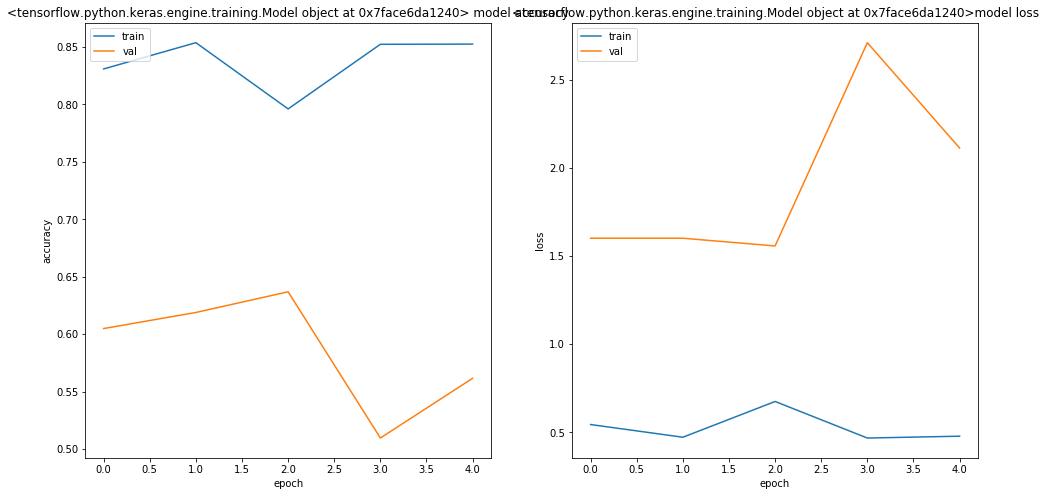

1563/1563 [==============================] - 7s 4ms/sample
                              precision    recall  f1-score   support

                   aerosmith       0.49      0.47      0.48        38
                     beatles       0.60      0.67      0.63        78
creedence_clearwater_revival       0.85      0.86      0.85       105
                        cure       0.30      0.59      0.40       141
          dave_matthews_band       0.93      0.39      0.55       147
                depeche_mode       0.49      0.43      0.46        54
               fleetwood_mac       0.19      0.30      0.23        33
                garth_brooks       0.85      0.92      0.88        36
                   green_day       0.83      0.73      0.78        86
                led_zeppelin       0.90      0.17      0.29       162
                     madonna       0.70      0.54      0.61        87
                   metallica       0.99      0.91      0.95       161
                      prince  

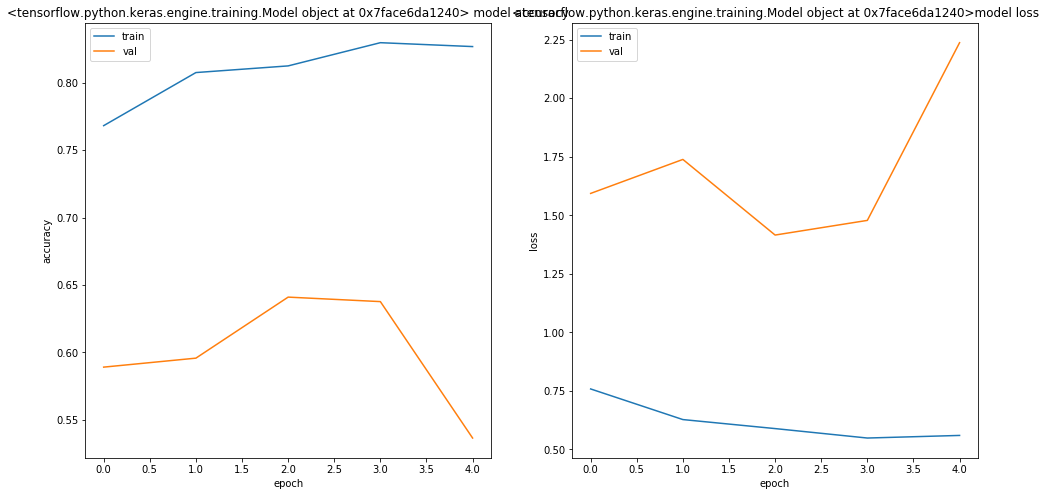

1563/1563 [==============================] - 7s 4ms/sample
                              precision    recall  f1-score   support

                   aerosmith       0.44      0.68      0.54        38
                     beatles       0.73      0.55      0.63        78
creedence_clearwater_revival       0.86      0.85      0.86       105
                        cure       0.42      0.07      0.12       141
          dave_matthews_band       0.74      0.81      0.78       147
                depeche_mode       0.26      0.81      0.39        54
               fleetwood_mac       0.20      0.18      0.19        33
                garth_brooks       0.69      0.94      0.80        36
                   green_day       0.96      0.59      0.73        86
                led_zeppelin       0.54      0.59      0.56       162
                     madonna       0.64      0.55      0.59        87
                   metallica       0.95      0.93      0.94       161
                      prince  

In [30]:
train_model(CRTLnn_model_20,20,epochs=5)